In [ ]:
# Download and unzip dataset
!pip install kaggle timm --quiet

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!mkdir -p /content/drive/MyDrive/BrainTumorProject/Data/
!unzip -q brain-tumor-mri-dataset.zip -d /content/drive/MyDrive/BrainTumorProject/Data/

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 1.59GB/s]
replace /content/drive/MyDrive/BrainTumorProject/Data/Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# image transforms
import os
from torchvision import transforms
from PIL import Image

train_dir = '/content/drive/MyDrive/BrainTumorProject/Data/Training'
test_dir  = '/content/drive/MyDrive/BrainTumorProject/Data/Testing'

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.RandomAffine(degrees=0, scale=(0.8,1.2), shear=15),
    transforms.ToTensor(),  # scales to [0,1]
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# quick check classes
classes = sorted(os.listdir(train_dir))
print("Detected classes:", classes)

Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# count images per class
def count_images_per_class(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[class_name] = num_images
    return class_counts

train_counts = count_images_per_class(train_dir)
test_counts  = count_images_per_class(test_dir)

print("Training set image counts:")
for cls, count in train_counts.items():
    print(f"  {cls}: {count} images")

print("\nTesting set image counts:")
for cls, count in test_counts.items():
    print(f"  {cls}: {count} images")

print(f"\nTotal training images: {sum(train_counts.values())}")
print(f"Total testing images:  {sum(test_counts.values())}")

Training set image counts:
  glioma: 1321 images
  meningioma: 1339 images
  notumor: 1595 images
  pituitary: 1457 images

Testing set image counts:
  glioma: 300 images
  meningioma: 306 images
  notumor: 405 images
  pituitary: 300 images

Total training images: 5712
Total testing images:  1311


In [ ]:
# gather image paths and labels, then do a single train/val split
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")  # quiet common warnings

valid_ext = {'.jpg', '.jpeg', '.png'}
image_paths = []
labels = []
for cls in classes:
    cls_dir = os.path.join(train_dir, cls)
    for p in glob.glob(os.path.join(cls_dir, '*')):
        if os.path.splitext(p)[1].lower() in valid_ext:
            image_paths.append(p)
            labels.append(classes.index(cls))
print("Total train images found:", len(image_paths))

# single train/val split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.1, random_state=42, stratify=np.array(labels)
)

print("Train/Val split sizes:", len(train_paths), len(val_paths))

# quick dataset class (used later)
class BrainTumorDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# example dataloaders (not mandatory; train function will create its own)
train_ds = BrainTumorDataset(train_paths, train_labels, transform=train_transform)
val_ds   = BrainTumorDataset(val_paths, val_labels, transform=val_transform)
print("Datasets ready. Train/Val sizes:", len(train_ds), len(val_ds))

Total train images found: 5712
Train/Val split sizes: 5140 572
Datasets ready. Train/Val sizes: 5140 572


In [ ]:
# show class counts in the single split
from collections import Counter

tr_counts = Counter(train_labels)
va_counts = Counter(val_labels)

print("Train class counts:")
for k,v in tr_counts.items():
    print(f"  {classes[k]}: {v}")

print("Val class counts:")
for k,v in va_counts.items():
    print(f"  {classes[k]}: {v}")

Train class counts:
  pituitary: 1311
  meningioma: 1205
  notumor: 1435
  glioma: 1189
Val class counts:
  notumor: 160
  glioma: 132
  meningioma: 134
  pituitary: 146


In [ ]:
# reproducibility and save split indices
import random, numpy as np, torch, json, os
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

save_path = '/content/drive/MyDrive/BrainTumorProject/Data/split_indices.json'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
save_dict = {
    "train_paths": train_paths,
    "val_paths": val_paths,
    "train_labels": train_labels,
    "val_labels": val_labels
}
with open(save_path, 'w') as f:
    json.dump(save_dict, f)
print("Saved split to", save_path)

Saved split to /content/drive/MyDrive/BrainTumorProject/Data/split_indices.json


In [ ]:
# EfficientNet-B7 instantiation
import timm, torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_effnet = timm.create_model('tf_efficientnet_b7', pretrained=True, num_classes=len(classes)).to(device)
print("EffNet-B7 params:", sum(p.numel() for p in model_effnet.parameters() if p.requires_grad))

model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

EffNet-B7 params: 63797204


In [ ]:
# Swin transformer
import timm, torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
try:
    model_swin = timm.create_model('swin_small_patch4_window7_224', pretrained=True, num_classes=len(classes))
except Exception:
    model_swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(classes))
model_swin = model_swin.to(device)
print("Swin params:", sum(p.numel() for p in model_swin.parameters() if p.requires_grad))

model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

Swin params: 48840334


In [ ]:
# training utilities
import os
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

save_dir = "/content/drive/MyDrive/BrainTumorProject/Models"
os.makedirs(save_dir, exist_ok=True)

def train_single_model(model, train_paths, train_labels, val_paths, val_labels,
                       epochs=50, batch_size=64, lr=1e-4, model_name="Model"):
    train_ds = BrainTumorDataset(train_paths, train_labels, transform=train_transform)
    val_ds   = BrainTumorDataset(val_paths, val_labels, transform=val_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

    best_acc = 0.0
    best_path = os.path.join(save_dir, f"{model_name}.pth")

    for epoch in range(epochs):
        model.train()
        for imgs, lbls in tqdm(train_loader, desc=f"{model_name} | Epoch {epoch+1}/{epochs}", leave=False):
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                out = model(imgs)
                loss = criterion(out, lbls)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # validation
        val_preds, val_trues = [], []
        model.eval()
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs = imgs.to(device)
                out = model(imgs)
                preds = torch.argmax(out, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_trues.extend(lbls.numpy())

        acc = accuracy_score(val_trues, val_preds)
        prec, rec, f1, _ = precision_recall_fscore_support(val_trues, val_preds, average='macro', zero_division=0)
        print(f"Epoch [{epoch+1}/{epochs}] | Val Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), best_path)
            print(f"✅ Saved best model: {best_path} (Acc: {best_acc:.4f})")

    print(f"Best accuracy for {model_name}: {best_acc:.4f}")
    return best_acc, prec, rec, f1

def train(model_class, model_name="Model", epochs=50, batch_size=64, lr=1e-4):
    print(f"\n===== Train {model_name} =====")
    model = model_class()
    metrics = train_single_model(
        model, train_paths, train_labels, val_paths, val_labels,
        epochs=epochs, batch_size=batch_size, lr=lr, model_name=model_name
    )
    torch.cuda.empty_cache()
    return metrics

In [ ]:
# train EfficientNet-B7
train(lambda: timm.create_model('tf_efficientnet_b7', pretrained=True, num_classes=len(classes)),
      model_name="EfficientNet-B7", epochs=8, batch_size=48, lr=1e-4)


===== Train EfficientNet-B7 =====


Epoch [1/8] | Val Acc: 0.8881 | Prec: 0.8909 | Rec: 0.8812 | F1: 0.8821
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.8881)


Epoch [2/8] | Val Acc: 0.9178 | Prec: 0.9156 | Rec: 0.9138 | F1: 0.9144
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.9178)


Epoch [3/8] | Val Acc: 0.9545 | Prec: 0.9544 | Rec: 0.9528 | F1: 0.9535
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.9545)


Epoch [4/8] | Val Acc: 0.9493 | Prec: 0.9496 | Rec: 0.9460 | F1: 0.9469


Epoch [5/8] | Val Acc: 0.9668 | Prec: 0.9665 | Rec: 0.9646 | F1: 0.9653
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.9668)


Epoch [6/8] | Val Acc: 0.9703 | Prec: 0.9706 | Rec: 0.9685 | F1: 0.9690
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.9703)


Epoch [7/8] | Val Acc: 0.9650 | Prec: 0.9643 | Rec: 0.9638 | F1: 0.9639


Epoch [8/8] | Val Acc: 0.9633 | Prec: 0.9633 | Rec: 0.9616 | F1: 0.9617
Best accuracy for EfficientNet-B7: 0.9703


(0.9702797202797203,
 0.9633315565547735,
 0.9616173394391678,
 0.9617406097678759)

In [ ]:
# train Swin Transformer once
train(lambda: timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=len(classes)),
      model_name="Swin-Transformer", epochs=5, batch_size=32, lr=1e-4)


===== Train Swin-Transformer =====


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch [1/5] | Val Acc: 0.9493 | Prec: 0.9489 | Rec: 0.9469 | F1: 0.9472
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth (Acc: 0.9493)


Epoch [2/5] | Val Acc: 0.9633 | Prec: 0.9668 | Rec: 0.9609 | F1: 0.9625
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth (Acc: 0.9633)


Epoch [3/5] | Val Acc: 0.9790 | Prec: 0.9789 | Rec: 0.9780 | F1: 0.9783
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth (Acc: 0.9790)


Epoch [4/5] | Val Acc: 0.9843 | Prec: 0.9842 | Rec: 0.9833 | F1: 0.9837
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth (Acc: 0.9843)


Epoch [5/5] | Val Acc: 0.9720 | Prec: 0.9740 | Rec: 0.9703 | F1: 0.9711
Best accuracy for Swin-Transformer: 0.9843


(0.9842657342657343,
 0.9740111693816893,
 0.9702743288538627,
 0.9711345275031138)

In [ ]:
# Cell 2: imports and load saved split indices from Drive
import os, json, random
import numpy as np
from collections import Counter
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# path to your saved split on Drive (you created this earlier)
split_path = '/content/drive/MyDrive/BrainTumorProject/Data/split_indices.json'
assert os.path.exists(split_path), f"Split file not found: {split_path}"
with open(split_path, 'r') as f:
    split = json.load(f)

train_paths = split['train_paths']
val_paths   = split['val_paths']
train_labels = split['train_labels']
val_labels   = split['val_labels']

print("Loaded splits — train:", len(train_paths), "val:", len(val_paths))
print("Train label distribution:", Counter(train_labels))
print("Val label distribution:",   Counter(val_labels))

Loaded splits — train: 5140 val: 572
Train label distribution: Counter({2: 1435, 3: 1311, 1: 1205, 0: 1189})
Val label distribution: Counter({2: 160, 3: 146, 1: 134, 0: 132})


In [ ]:
# Cell 3: dataset, transforms and dataloaders
from torchvision import transforms

IMG_SIZE = 224  # matches the DeiT/Vit trained resolution
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, scale=(0.9,1.1), shear=10),
    transforms.ToTensor(),
    # Normalize using ImageNet stats (pretrained ViT/DeiT expect this)
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class BrainTumorDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, int(self.labels[idx])

train_ds = BrainTumorDataset(train_paths, train_labels, transform=train_transform)
val_ds   = BrainTumorDataset(val_paths, val_labels, transform=val_transform)

# adjust batch size to fit your GPU — increase if you have >16GB VRAM
BATCH_SIZE = 48

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
# Cell 4: model, optimizer and scheduler
import timm
import torch.nn as nn
import torch.optim as optim

NUM_CLASSES = len(set(train_labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Try DeiT small distilled first. If it fails, fallback to vit_base or deit_base.
model_name = 'deit_small_distilled_patch16_224'  # good starting point for smaller datasets
try:
    model = timm.create_model(model_name, pretrained=True, num_classes=NUM_CLASSES)
except Exception as e:
    print("Failed to load", model_name, "— fallback to vit_base_patch16_224. Error:", e)
    model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES)

model.to(device)

# optimizer and scheduler
LR = 3e-4
WEIGHT_DECAY = 0.05
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Cosine annealing with warmup (simple warmup implemented manually)
from torch.optim.lr_scheduler import CosineAnnealingLR
EPOCHS = 6  # modest number, as requested
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

Device: cuda


model.safetensors:   0%|          | 0.00/89.8M [00:00<?, ?B/s]

In [ ]:
# Cell 5: training loop (mixed precision), only save best model locally and copy to Drive at end
import time
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
scaler = GradScaler()  # AMP

best_val_acc = 0.0
best_path_local = '/content/best_vit.pth'

def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = imgs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            with autocast():
                outputs = model(imgs)
                loss = criterion(outputs, targets)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += imgs.size(0)
    avg_loss = running_loss / total
    acc = correct / total * 100.0
    return avg_loss, acc

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    t0 = time.time()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for imgs, targets in pbar:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad()
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += imgs.size(0)

        pbar.set_postfix(loss=epoch_loss/total, acc=100.0*correct/total)

    scheduler.step()
    train_loss = epoch_loss / total
    train_acc = 100.0 * correct / total
    val_loss, val_acc = evaluate(model, val_loader)
    epoch_time = time.time() - t0
    print(f"Epoch {epoch}/{EPOCHS} — time: {int(epoch_time)}s — train_loss: {train_loss:.4f} train_acc: {train_acc:.2f}% | val_loss: {val_loss:.4f} val_acc: {val_acc:.2f}%")

    # save best locally only
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, best_path_local)
        print(f"Saved NEW best local checkpoint with val_acc={val_acc:.2f}% -> {best_path_local}")

print(f"Training complete. Best val_acc: {best_val_acc:.2f}%")
# copy best to Drive (single file)
drive_target = '/content/drive/MyDrive/BrainTumorProject/Models/best_deit_small.pth'
os.makedirs(os.path.dirname(drive_target), exist_ok=True)
if os.path.exists(best_path_local):
    import shutil
    shutil.copy(best_path_local, drive_target)
    print("Copied best model to Drive:", drive_target)
else:
    print("No best model file found to copy.")

Epoch 1/6 — time: 47s — train_loss: 0.3774 train_acc: 85.91% | val_loss: 0.1942 val_acc: 92.13%
Saved NEW best local checkpoint with val_acc=92.13% -> /content/best_vit.pth


Epoch 2/6 — time: 42s — train_loss: 0.1894 train_acc: 93.15% | val_loss: 0.1482 val_acc: 94.41%
Saved NEW best local checkpoint with val_acc=94.41% -> /content/best_vit.pth


Epoch 3/6 — time: 42s — train_loss: 0.1306 train_acc: 95.60% | val_loss: 0.1254 val_acc: 96.15%
Saved NEW best local checkpoint with val_acc=96.15% -> /content/best_vit.pth


Epoch 4/6 — time: 42s — train_loss: 0.0877 train_acc: 96.79% | val_loss: 0.0477 val_acc: 98.25%
Saved NEW best local checkpoint with val_acc=98.25% -> /content/best_vit.pth


Epoch 5/6 — time: 42s — train_loss: 0.0531 train_acc: 98.07% | val_loss: 0.0219 val_acc: 99.65%
Saved NEW best local checkpoint with val_acc=99.65% -> /content/best_vit.pth


Epoch 6/6 — time: 42s — train_loss: 0.0294 train_acc: 99.07% | val_loss: 0.0209 val_acc: 98.95%
Training complete. Best val_acc: 99.65%
Copied best model to Drive: /content/drive/MyDrive/BrainTumorProject/Models/best_deit_small.pth


In [ ]:
# Cell 1: imports and basic settings
import os
import json
import math
from collections import Counter
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- User-adjustable settings ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_FOLDS = 5
GRID_RESOLUTION = 10  # grid step = 1/GRID_RESOLUTION (10 -> step 0.1)
SEED = 42

# Paths
SPLIT_PATH = '/content/drive/MyDrive/BrainTumorProject/Data/split_indices.json'
MODELS_DIR = '/content/drive/MyDrive/BrainTumorProject/Models'

# Model configurations
MODELS_INFO = [
    {
        "display_name": "deit_small_distilled",
        "timm_name": "deit_small_distilled_patch16_224",
        "path": os.path.join(MODELS_DIR, 'best_deit_small.pth')
    },
    {
        "display_name": "efficientnet_b7",
        "timm_name": "tf_efficientnet_b7",
        "path": os.path.join(MODELS_DIR, 'EfficientNet-B7.pth')
    },
    {
        "display_name": "swin_base",
        "timm_name": "swin_base_patch4_window7_224",
        "path": os.path.join(MODELS_DIR, 'Swin-Transformer.pth')
    },
]

# --- Reproducibility ---
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [ ]:
# Cell 2: load split file and create small dataset class used for inference
assert os.path.exists(SPLIT_PATH), f"Split file not found: {SPLIT_PATH}"

with open(SPLIT_PATH, 'r') as f:
    split = json.load(f)

train_paths = split['train_paths']
train_labels = list(map(int, split['train_labels']))
val_paths = split['val_paths']
val_labels = list(map(int, split['val_labels']))

print(f"Train: {len(train_paths)} samples, Val: {len(val_paths)} samples")
print("Train label distribution:", Counter(train_labels))

# Transforms (must match validation transforms used earlier)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class SimpleImageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, int(self.labels[idx])


Train: 5140 samples, Val: 572 samples
Train label distribution: Counter({2: 1435, 3: 1311, 1: 1205, 0: 1189})


In [ ]:
# Cell 3: helper to instantiate and load models

def load_model(timm_name, model_path, num_classes, device=DEVICE):
    print(f"Loading model {timm_name} from {model_path}")

    # create model architecture
    try:
        model = timm.create_model(timm_name, pretrained=False, num_classes=num_classes)
    except Exception as e:
        print(f"Failed to instantiate {timm_name}: {e}")
        raise

    # load saved state
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    sd = torch.load(model_path, map_location=device)

    # handle checkpoint dicts
    if isinstance(sd, dict) and 'model_state_dict' in sd:
        sd = sd['model_state_dict']

    # load weights (strict → fallback to non-strict)
    try:
        model.load_state_dict(sd, strict=False)
    except Exception as e:
        print("Warning: strict load failed, attempting non-strict. Error:", e)
        model.load_state_dict(sd, strict=False)

    model.to(device)
    model.eval()
    return model


In [ ]:
# Cell 4: precompute softmax probabilities for each model on the TRAIN set (for CV) and VAL set (final eval)

# instantiate datasets/loaders (shuffle=False to keep index order)
train_ds_full = SimpleImageDataset(train_paths, train_labels, transform=val_transform)
val_ds_full = SimpleImageDataset(val_paths, val_labels, transform=val_transform)

train_loader_full = DataLoader(
    train_ds_full, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)
val_loader_full = DataLoader(
    val_ds_full, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)

NUM_CLASSES = len(set(train_labels))
NUM_MODELS = len(MODELS_INFO)

# containers for per-model predictions
train_probs = np.zeros((NUM_MODELS, len(train_ds_full), NUM_CLASSES), dtype=np.float32)
val_probs = np.zeros((NUM_MODELS, len(val_ds_full), NUM_CLASSES), dtype=np.float32)

for m_idx, minfo in enumerate(MODELS_INFO):

    model = load_model(
        minfo['timm_name'],
        minfo['path'],
        num_classes=NUM_CLASSES,
        device=DEVICE
    )

    # ---- TRAIN SET ----
    ptr = 0
    with torch.no_grad():
        for imgs, _ in tqdm(
            train_loader_full,
            desc=f"[{m_idx+1}/{NUM_MODELS}] Predicting TRAIN - {minfo['display_name']}"
        ):
            imgs = imgs.to(DEVICE, non_blocking=True)
            out = model(imgs)
            probs = torch.softmax(out, dim=1).cpu().numpy()

            bs = probs.shape[0]
            train_probs[m_idx, ptr:ptr+bs, :] = probs
            ptr += bs

    assert ptr == len(train_ds_full), f"Train pred count mismatch for model {minfo['display_name']}"

    # ---- VAL SET ----
    ptr = 0
    with torch.no_grad():
        for imgs, _ in tqdm(
            val_loader_full,
            desc=f"[{m_idx+1}/{NUM_MODELS}] Predicting VAL - {minfo['display_name']}"
        ):
            imgs = imgs.to(DEVICE, non_blocking=True)
            out = model(imgs)
            probs = torch.softmax(out, dim=1).cpu().numpy()

            bs = probs.shape[0]
            val_probs[m_idx, ptr:ptr+bs, :] = probs
            ptr += bs

    assert ptr == len(val_ds_full), f"Val pred count mismatch for model {minfo['display_name']}"

print("Precomputed probabilities for all models.")


Loading model deit_small_distilled_patch16_224 from /content/drive/MyDrive/BrainTumorProject/Models/best_deit_small.pth


[1/3] Predicting VAL - deit_small_distilled: 100%|██████████| 9/9 [00:04<00:00,  2.13it/s]


Loading model tf_efficientnet_b7 from /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth


[2/3] Predicting VAL - efficientnet_b7: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


Loading model swin_base_patch4_window7_224 from /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth


[3/3] Predicting VAL - swin_base: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]

Precomputed probabilities for all models.


In [ ]:
# Cell 5: build grid of weight combinations that sum to 1 (for 3 models)

def simplex_grid(num_models, resolution):

    if num_models == 1:
        return [np.array([1.0])]

    if num_models == 2:
        ws = []
        for i in range(resolution+1):
            a = i / resolution
            ws.append(np.array([a, 1.0 - a]))
        return ws

    if num_models == 3:
        ws = []
        for i in range(resolution+1):
            for j in range(resolution+1-i):
                k = resolution - i - j
                w = np.array([i / resolution, j / resolution, k / resolution], dtype=np.float32)
                ws.append(w)
        return ws

    # generic recursive solution (careful: combinatorial explosion)
    def rec(remaining, parts):
        if parts == 1:
            return [[remaining]]
        out = []
        for i in range(remaining+1):
            for tail in rec(remaining - i, parts - 1):
                out.append([i] + tail)
        return out

    ints = rec(resolution, num_models)
    ws = [np.array(v, dtype=np.float32) / resolution for v in ints]
    return ws


weights_grid = simplex_grid(NUM_MODELS, GRID_RESOLUTION)
print(f"Generated {len(weights_grid)} weight combinations (resolution={GRID_RESOLUTION})")


Generated 66 weight combinations (resolution=10)


In [ ]:
# Cell 6: cross-validated grid search for weights (StratifiedKFold on the TRAIN set)

skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
train_indices = np.arange(len(train_ds_full))

best_weights = None
best_score = -1.0

print("Running grid search over weights with StratifiedKFold CV")

for w_idx, weights in enumerate(tqdm(weights_grid, desc='Grid')):

    # fast skip if any tiny numeric negative (shouldn't happen)
    weights = np.maximum(weights, 0.0)

    # normalize just in case
    if weights.sum() == 0:
        continue
    weights = weights / weights.sum()

    fold_scores = []

    for train_idx, valid_idx in skf.split(train_indices, train_labels):

        # compute weighted probs for validation fold
        probs_valid = train_probs[:, valid_idx, :]   # (n_models, n_fold, n_classes)

        # weighted sum over models → shape (n_fold, n_classes)
        weighted = np.tensordot(weights, probs_valid, axes=(0, 0))

        preds = np.argmax(weighted, axis=1)
        acc = accuracy_score(np.array(train_labels)[valid_idx], preds)

        fold_scores.append(acc)

    mean_score = float(np.mean(fold_scores))

    if mean_score > best_score:
        best_score = mean_score
        best_weights = weights.copy()

print(f"Best CV mean accuracy: {best_score:.4f} with weights: {best_weights}")

# Save best weights
out_json = os.path.join(MODELS_DIR, 'best_ensemble_weights.json')
with open(out_json, 'w') as f:
    json.dump({
        "weights": best_weights.tolist(),
        "cv_acc": float(best_score),
        "models": [m['display_name'] for m in MODELS_INFO]
    }, f, indent=2)

print("Saved best weights to", out_json)


Running grid search over weights with StratifiedKFold CV


Grid: 100%|██████████| 66/66 [00:00<00:00, 94.69it/s]

Best CV mean accuracy: 0.9934 with weights: [0.8 0.  0.2]
Saved best weights to /content/drive/MyDrive/BrainTumorProject/Models/best_ensemble_weights.json


In [ ]:
# Cell 7: evaluate chosen weights on the held-out VAL set and produce a report

best_weights = np.array(best_weights)
best_weights = best_weights / best_weights.sum()

# compute weighted probs on val set
weighted_val = np.tensordot(best_weights, val_probs, axes=(0, 0))  # (n_val, num_classes)
val_preds = np.argmax(weighted_val, axis=1)
val_acc = accuracy_score(val_labels, val_preds)

print(f"Ensemble val accuracy: {val_acc:.4f}")
print('\nClassification report:')
print(classification_report(val_labels, val_preds, digits=4))

print('\nConfusion matrix:')
print(confusion_matrix(val_labels, val_preds))

# optional: show per-class accuracy
from collections import defaultdict
per_class = defaultdict(lambda: [0, 0])

for t, p in zip(val_labels, val_preds):
    per_class[t][1] += 1
    if t == p:
        per_class[t][0] += 1

print('\nPer-class accuracy:')
for k, (correct, total) in per_class.items():
    print(f"class {k}: {correct}/{total} = {correct/total:.4f}")


Ensemble val accuracy: 0.9965

Classification report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       132
           1     0.9925    0.9925    0.9925       134
           2     0.9938    1.0000    0.9969       160
           3     1.0000    0.9932    0.9966       146

    accuracy                         0.9965       572
   macro avg     0.9966    0.9964    0.9965       572
weighted avg     0.9965    0.9965    0.9965       572


Confusion matrix:
[[132   0   0   0]
 [  0 133   1   0]
 [  0   0 160   0]
 [  0   1   0 145]]

Per-class accuracy:
class 2: 160/160 = 1.0000
class 0: 132/132 = 1.0000
class 1: 133/134 = 0.9925
class 3: 145/146 = 0.9932


Done. You can change GRID_RESOLUTION, NUM_FOLDS or add/remove models from MODELS_INFO and re-run.


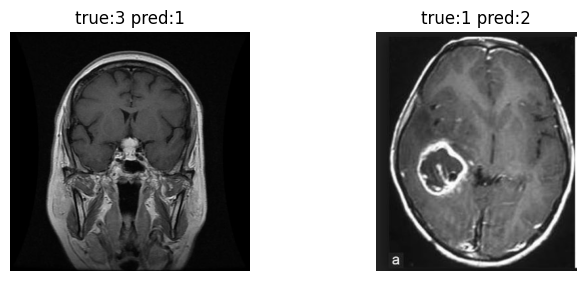

In [ ]:
# Cell 8: quick utility to examine a few misclassified images (optional)

SHOW_MIS = 12

mis_idx = [i for i, (t, p) in enumerate(zip(val_labels, val_preds)) if t != p]

from matplotlib import pyplot as plt

plt.figure(figsize=(14, 8))

for i, idx in enumerate(mis_idx[:SHOW_MIS]):
    img = Image.open(val_paths[idx]).convert('RGB')
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"true:{val_labels[idx]} pred:{val_preds[idx]}")

plt.tight_layout()

print('Done. You can change GRID_RESOLUTION, NUM_FOLDS or add/remove models from MODELS_INFO and re-run.')


In [ ]:
# PLOT CELL 1: plotting setup & helpers (run first)
import os, json, math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from sklearn.calibration import calibration_curve
from collections import defaultdict

# adjust these to your Drive paths if desired
FIG_DIR = "./figures"
MODELS_DIR = "/content/drive/MyDrive/BrainTumorProject/Models"
os.makedirs(FIG_DIR, exist_ok=True)
if os.path.exists(MODELS_DIR):
    os.makedirs(os.path.join(MODELS_DIR, "figures"), exist_ok=True)

# class names mapping (use the same order as your `classes` variable)
# If you defined `classes` earlier in the notebook, this will reuse it.
try:
    CLASS_NAMES = classes  # from earlier cells
except NameError:
    # default order from your dataset
    CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Helper: ensure we have val_labels, val_preds, and weighted_val (probabilities)
_missing = []
if 'val_labels' not in globals():
    _missing.append('val_labels')
if 'val_preds' not in globals():
    # maybe the notebook computed val_preds earlier; if not, we'll try to reconstruct
    pass
if 'weighted_val' not in globals():
    # attempt to reconstruct if val_probs and a saved best weights json exist
    try:
        if 'val_probs' in globals() and os.path.exists(os.path.join(MODELS_DIR, 'best_ensemble_weights.json')):
            with open(os.path.join(MODELS_DIR, 'best_ensemble_weights.json'),'r') as f:
                bw = json.load(f)['weights']
            # val_probs shape expected: (n_models, n_val, n_classes)
            weighted_val = np.tensordot(np.array(bw), val_probs, axes=(0,0))
            val_preds = np.argmax(weighted_val, axis=1)
            print("Reconstructed weighted_val from in-memory val_probs + best_ensemble_weights.json")
        else:
            # if val_preds exists but weighted_val missing, try to compute weighted_val from val_preds? not possible
            pass
    except Exception as e:
        print("Could not reconstruct weighted_val automatically:", e)

# Final checks
if 'val_labels' not in globals() or ('val_preds' not in globals() and 'weighted_val' not in globals()):
    raise RuntimeError(
        "Missing required arrays. Ensure `val_labels` and either `val_preds` or `weighted_val` (probabilities) are present in the session. "
        "If you saved `best_ensemble_weights.json` and `val_probs` (npy), place them in Models dir and re-run."
    )

# If only weighted_val exists but val_preds not, compute them
if 'weighted_val' in globals() and 'val_preds' not in globals():
    val_preds = np.argmax(weighted_val, axis=1)

# convert to numpy arrays
val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
n_classes = len(CLASS_NAMES)

print(f"Found {len(val_labels)} validation samples, {n_classes} classes.")


Found 572 validation samples, 4 classes.


Saved: ./figures/confusion_matrix_counts.png
Also copied to: /content/drive/MyDrive/BrainTumorProject/Models/figures


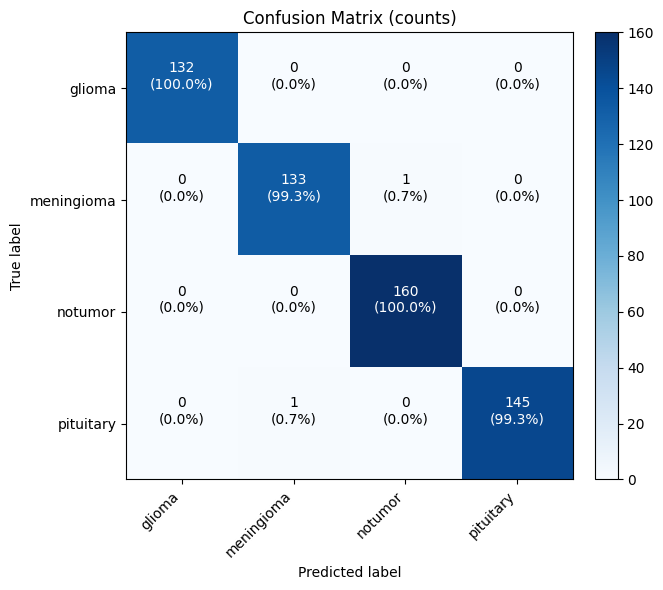

In [ ]:
# PLOT CELL 2: confusion matrix (counts) with annotations
cm = confusion_matrix(val_labels, val_preds, labels=range(n_classes))
cm_counts = cm.astype(int)
cm_sum = cm_counts.sum()
plt.figure(figsize=(7,6))
im = plt.imshow(cm_counts, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (counts)")
plt.colorbar(im, fraction=0.046, pad=0.04)
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, CLASS_NAMES, rotation=45, ha='right')
plt.yticks(tick_marks, CLASS_NAMES)

# annotate with counts and row percentages
thresh = cm_counts.max() / 2.
for i in range(cm_counts.shape[0]):
    for j in range(cm_counts.shape[1]):
        pct = cm_counts[i,j] / (cm_counts[i,:].sum() + 1e-12)
        txt = f"{cm_counts[i,j]}\n({pct*100:.1f}%)"
        plt.text(j, i, txt, horizontalalignment="center",
                 color="white" if cm_counts[i, j] > thresh else "black", fontsize=10)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "confusion_matrix_counts.png")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print("Saved:", out_path)
# copy to drive if available
if os.path.exists(MODELS_DIR):
    shutil.copy(out_path, os.path.join(MODELS_DIR, "figures", os.path.basename(out_path)))
    print("Also copied to:", os.path.join(MODELS_DIR, "figures"))
plt.show()


Saved: ./figures/confusion_matrix_norm.png


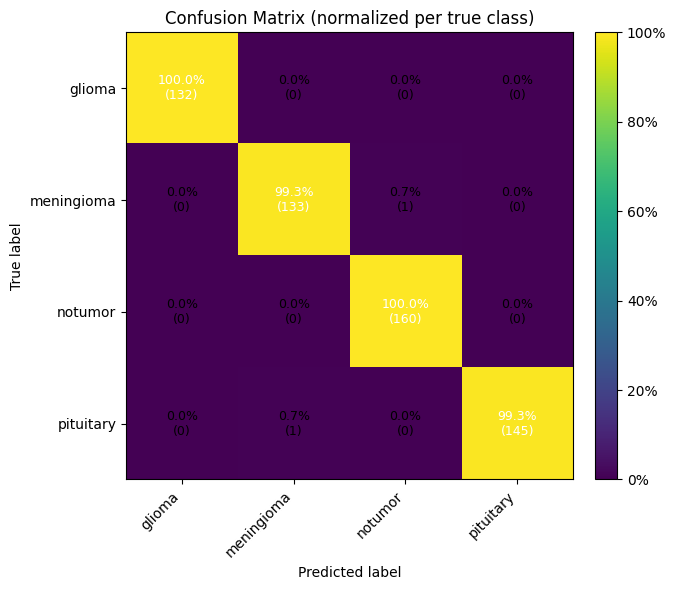

In [ ]:
# PLOT CELL 3: normalized confusion matrix (rows sum to 1)
cm = confusion_matrix(val_labels, val_preds, labels=range(n_classes)).astype(float)
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / (row_sums + 1e-12)

plt.figure(figsize=(7,6))
im = plt.imshow(cm_norm, interpolation='nearest', cmap='viridis', vmin=0, vmax=1)
plt.title("Confusion Matrix (normalized per true class)")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.xticks(np.arange(n_classes), CLASS_NAMES, rotation=45, ha='right')
plt.yticks(np.arange(n_classes), CLASS_NAMES)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        fmt = f"{cm_norm[i,j]*100:.1f}%\n({int(cm[i,j])})"
        plt.text(j, i, fmt, ha="center", va="center", color="white" if cm_norm[i,j] > 0.5 else "black", fontsize=9)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
out_path = os.path.join(FIG_DIR, "confusion_matrix_norm.png")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
if os.path.exists(MODELS_DIR):
    shutil.copy(out_path, os.path.join(MODELS_DIR, "figures", os.path.basename(out_path)))
print("Saved:", out_path)
plt.show()


Saved: ./figures/per_class_accuracy.png


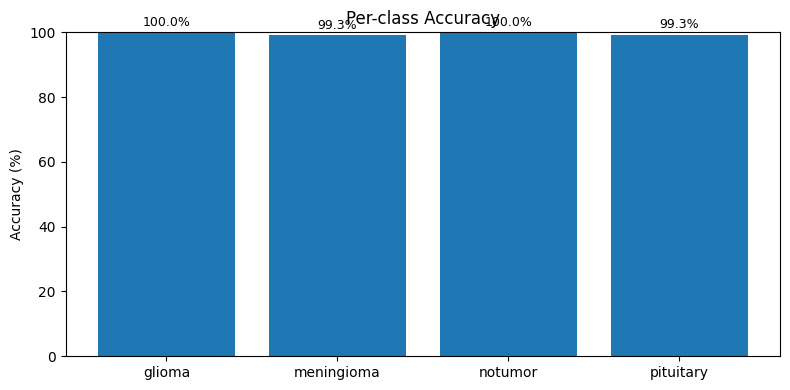

In [ ]:
# PLOT CELL 4: per-class accuracy bar chart
correct = np.diag(cm_counts if 'cm_counts' in globals() else confusion_matrix(val_labels, val_preds))
total_per_class = np.array([ (val_labels==i).sum() for i in range(n_classes) ])
acc_per_class = correct / (total_per_class + 1e-12)

plt.figure(figsize=(8,4))
bars = plt.bar(CLASS_NAMES, acc_per_class*100)
plt.ylim(0,100)
plt.ylabel("Accuracy (%)")
plt.title("Per-class Accuracy")
for bar, acc in zip(bars, acc_per_class):
    h = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, h+1, f"{acc*100:.1f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
out_path = os.path.join(FIG_DIR, "per_class_accuracy.png")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
if os.path.exists(MODELS_DIR):
    shutil.copy(out_path, os.path.join(MODELS_DIR, "figures", os.path.basename(out_path)))
print("Saved:", out_path)
plt.show()


Saved: ./figures/roc_multiclass.png


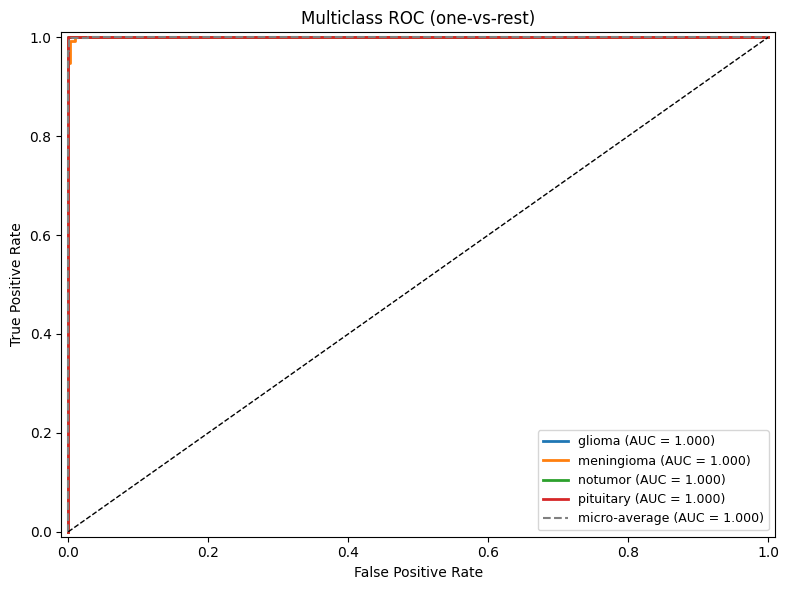

In [ ]:
# PLOT CELL 5: ROC curves + AUC (requires probability vectors)
if 'weighted_val' not in globals():
    raise RuntimeError("Need `weighted_val` (n_samples x n_classes) to plot ROC curves. Recompute ensemble probs first.")

y_score = weighted_val  # shape (n_val, n_classes)
y_true_bin = label_binarize(val_labels, classes=range(n_classes))
if y_true_bin.shape[1] != n_classes:
    # ensure shape
    y_true_bin = np.eye(n_classes)[val_labels]

plt.figure(figsize=(8,6))
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.3f})")

# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC = {roc_auc['micro']:.3f})", linestyle='--', color='grey')

plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlim([-0.01,1.01]); plt.ylim([-0.01,1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC (one-vs-rest)")
plt.legend(loc='lower right', fontsize=9)
plt.tight_layout()
out_path = os.path.join(FIG_DIR, "roc_multiclass.png")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
if os.path.exists(MODELS_DIR):
    shutil.copy(out_path, os.path.join(MODELS_DIR, "figures", os.path.basename(out_path)))
print("Saved:", out_path)
plt.show()


Saved: ./figures/pr_curves.png


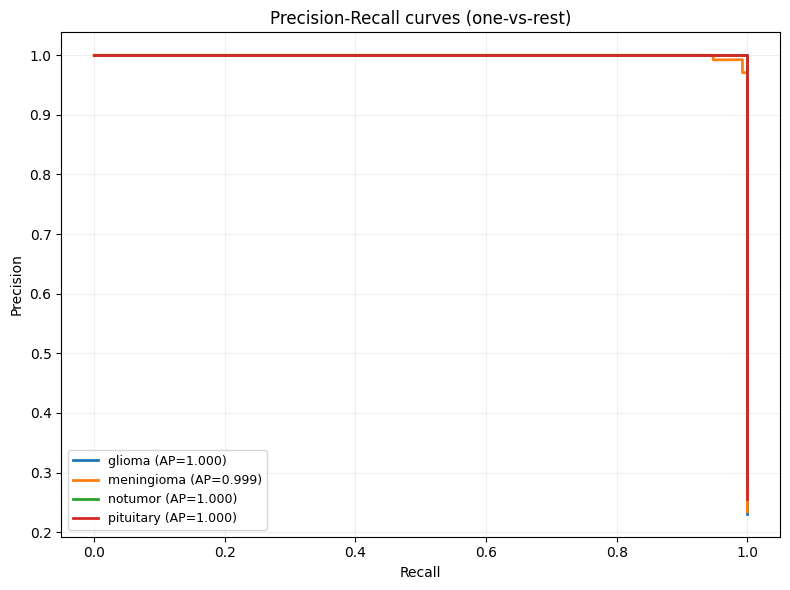

In [ ]:
# PLOT CELL 6: Precision-Recall curves and average precision
if 'weighted_val' not in globals():
    raise RuntimeError("Need `weighted_val` to plot PR curves. Recompute ensemble probs first.")

y_score = weighted_val
y_true_bin = label_binarize(val_labels, classes=range(n_classes))

plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:,i], y_score[:,i])
    ap = average_precision_score(y_true_bin[:,i], y_score[:,i])
    plt.plot(recall, precision, lw=2, label=f"{CLASS_NAMES[i]} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curves (one-vs-rest)")
plt.legend(loc='lower left', fontsize=9)
plt.grid(alpha=0.2)
plt.tight_layout()
out_path = os.path.join(FIG_DIR, "pr_curves.png")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
if os.path.exists(MODELS_DIR):
    shutil.copy(out_path, os.path.join(MODELS_DIR, "figures", os.path.basename(out_path)))
print("Saved:", out_path)
plt.show()


Saved: ./figures/tsne_probs_true_pred.png


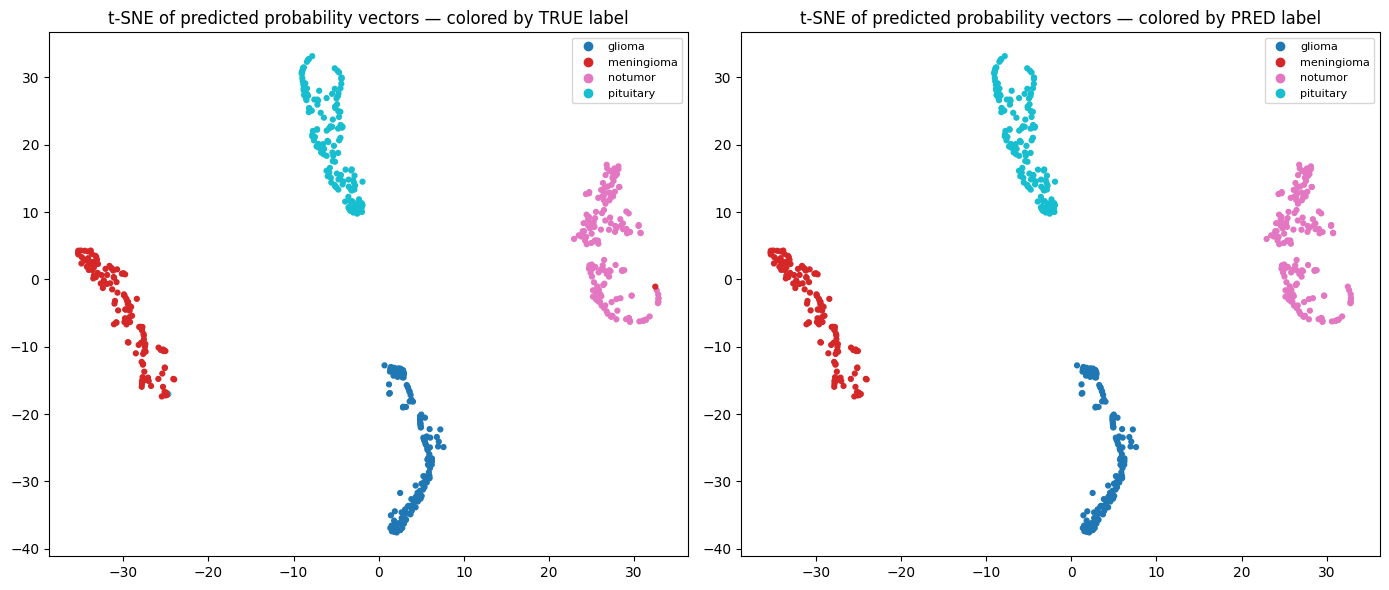

In [ ]:
# PLOT CELL 7: t-SNE of the softmax probability vectors (two panels: colored by true label and by predicted label)
if 'weighted_val' not in globals():
    raise RuntimeError("Need `weighted_val` (probabilities) for t-SNE.")

# use a PCA init / reduced dimension for speed if many samples; you can change perplexity
perplexity = 30 if len(val_labels) > 50 else max(5, len(val_labels)//3)
tsne = TSNE(n_components=2, perplexity=min(perplexity, max(5, len(val_labels)//3)), random_state=42, init='pca', learning_rate='auto', n_iter=1000)
tsne_emb = tsne.fit_transform(weighted_val)

fig, axes = plt.subplots(1,2, figsize=(14,6))
sc = axes[0].scatter(tsne_emb[:,0], tsne_emb[:,1], c=val_labels, cmap='tab10', s=12)
axes[0].set_title("t-SNE of predicted probability vectors — colored by TRUE label")
axes[0].legend(handles=sc.legend_elements()[0], labels=CLASS_NAMES, loc='best', fontsize=8)

sc2 = axes[1].scatter(tsne_emb[:,0], tsne_emb[:,1], c=val_preds, cmap='tab10', s=12)
axes[1].set_title("t-SNE of predicted probability vectors — colored by PRED label")
axes[1].legend(handles=sc2.legend_elements()[0], labels=CLASS_NAMES, loc='best', fontsize=8)

plt.tight_layout()
out_path = os.path.join(FIG_DIR, "tsne_probs_true_pred.png")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
if os.path.exists(MODELS_DIR):
    shutil.copy(out_path, os.path.join(MODELS_DIR, "figures", os.path.basename(out_path)))
print("Saved:", out_path)
plt.show()


Saved: ./figures/calibration_per_class.png


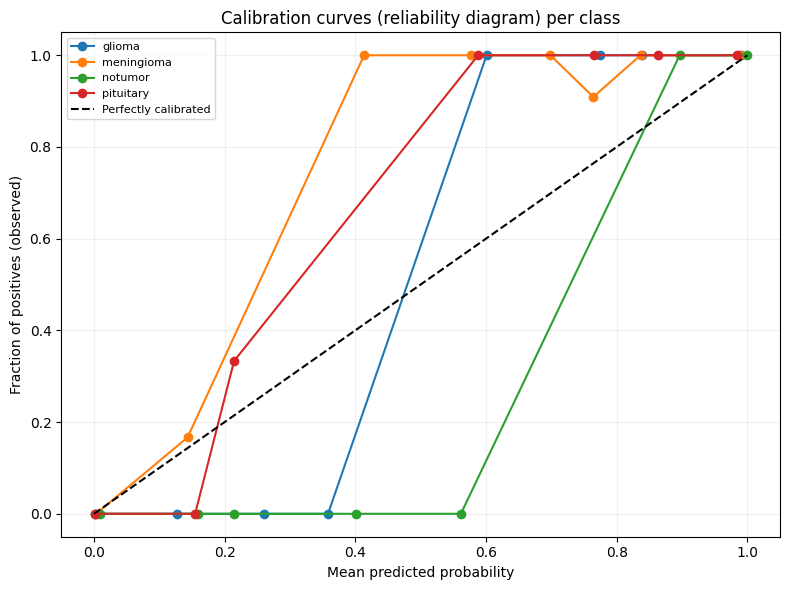

In [ ]:
# PLOT CELL 8: calibration (reliability) diagrams per class using predicted prob for that class
if 'weighted_val' not in globals():
    raise RuntimeError("Need `weighted_val` (probabilities) for calibration plots.")

plt.figure(figsize=(8,6))
for i in range(n_classes):
    prob_pos = weighted_val[:, i]
    true_pos = (val_labels == i).astype(int)
    frac_pos, mean_pred = calibration_curve(true_pos, prob_pos, n_bins=10, strategy='uniform')
    plt.plot(mean_pred, frac_pos, marker='o', label=f"{CLASS_NAMES[i]}")

plt.plot([0,1],[0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives (observed)')
plt.title('Calibration curves (reliability diagram) per class')
plt.legend(loc='best', fontsize=8)
plt.grid(alpha=0.2)
plt.tight_layout()
out_path = os.path.join(FIG_DIR, "calibration_per_class.png")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
if os.path.exists(MODELS_DIR):
    shutil.copy(out_path, os.path.join(MODELS_DIR, "figures", os.path.basename(out_path)))
print("Saved:", out_path)
plt.show()
